In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Generating Data

In [2]:
n_samples = 1500
# X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X = np.dot(X, transformation)
X, y = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=8)

**Utility Functions**

In [3]:
def get_silhouette_score(X, y):
    try:
        return silhouette_score(X, y)
    except ValueError:
        return -1

def plot(X, y, title):
    plt.scatter(X[:, 0], X[:, 1], cmap='Set1', c=y)
    plt.title(f"{title}, Score: {get_silhouette_score(X, y)}")

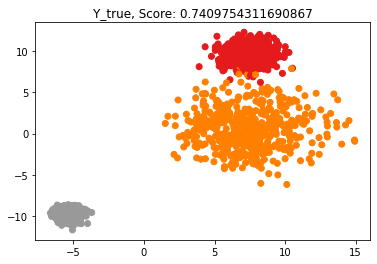

In [4]:
plot(X, y, 'Y_true')

# Defaut Parameters

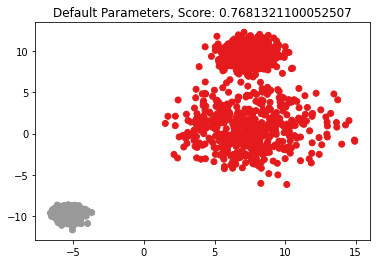

In [5]:
y_pred = AgglomerativeClustering(linkage='average').fit_predict(X)
plot(X, y_pred, 'Default Parameters');

# Hyperparameter Optiization

In [6]:
from functools import partial
from skopt import gp_minimize, space
from skopt.plots import plot_convergence

**Create an Optimization function that runs the model and returns a minimization metric**

In [7]:
def optimize(params, param_names, X, y, algo, metric, negate):
    params = dict(zip(param_names, params))
    try:
        model = algo(params)
        preds = model.fit_predict(X)
        opt_metric = metric(X, preds)
    except Exception as e:
        print(e, params)
        opt_metric = -1
    
    return -1 * opt_metric if negate else opt_metric

**Define the parameter space and run the optimization**

In [8]:
param_space = [
    space.Integer(3, 5, name="n_clusters"),
    space.Categorical(["euclidean", "l1", "l2", "manhattan", "cosine"], name="affinity"),
#     space.Real(1e-5, 1.0, name="distance_threshold")
]
param_names = [p.name for p in param_space]

algo = lambda params: AgglomerativeClustering(linkage="average", **params)

optimization_function = partial(
    optimize, param_names=param_names, X=X, y=y, algo=algo, metric=get_silhouette_score, negate=True
)
result = gp_minimize(optimization_function, dimensions=param_space, n_calls=10, n_random_starts=10)
best_params = dict(zip(param_names, result.x))
print(best_params)

{'n_clusters': 3, 'affinity': 'l1'}


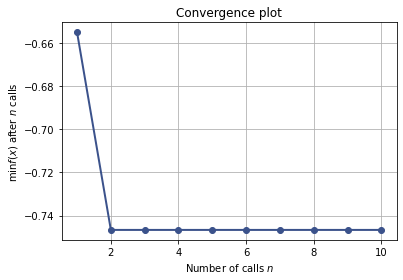

In [9]:
plot_convergence(result);

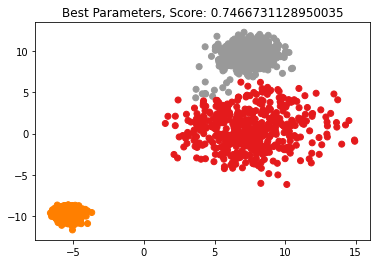

In [10]:
y_pred = algo(best_params).fit_predict(X)
plot(X, y_pred, 'Best Parameters');